# Tree-based Methods

## Simple Trees
### Principle

Decision trees seek to partition datasets into **homonegeous clusters**. Given an exogenuous variable $\boldsymbol{Y}$ and features $\boldsymbol{X}$, trees iteratively split the sample into groups with as homogeneous in $\boldsymbol{Y}$ as possible. 

Regression trees VS classification trees: whether $\boldsymbol{Y}$ is numerical or categorical.

Our idea can be formalized by the following figure:

![FIGURE 6.1: Elementary tree scheme; visualization of the splitting process](images\figure6-1.png)

The analogy to factor investing is also simple: The analogy with factor investing is simple: the color represents performance: red for high performance and blue for mediocre performance. The features (size and complexity of stars) are replaced by firm-specific attributes, such as capitalization, accounting ratios, etc. Hence, the purpose of the exercise is to find the characteristics that allow to *split firms into the ones that will perform well versus those likely to fare more poorly*.

Technical construction of *regression* trees (Breiman et al., 1984). Given a sample of $(y_i, \boldsymbol{x}_i)$, a *regression* tree seeks the splitting points that minimize the total variation of $y_i$ inside two child clusters. Two steps:

1. For each feature $x_i^{(k)}$, find the best splitting point (so that the clusters are homogeneous in $\boldsymbol{Y}$).
2. Select the feature that achieves the highest level of homogeneity.

Total variation should **take into account the relative size of clusters**. Hence, it it the **variance times the number of elements in the clusters**. With that, the steps are:

1. Find the best split for each feature, that is, solve $\text{argmin}_{c^{(k)}} V_I^{(k)}(c^{(k)})$ with
$$V^{(k)}_I(c^{(k}))= \underbrace{\sum_{x_i^{(k)}<c^{(k)}}\left(y_i-m_I^{k,-}(c^{(k)}) \right)^2}_{\text{Total dispersion of first cluster}} + \underbrace{\sum_{x_i^{(k)}>c^{(k)}}\left(y_i-m_I^{k,+}(c^{(k)}) \right)^2}_{\text{Total dispersion of second cluster}}$$
where
\begin{align*}
m_I^{k,-}(c^{(k)})&=\frac{1}{\#\{i,x_i^{(k)}<c^{(k)} \}}\sum_{\{x_i^{(k)}<c^{(k)} \}}y_i \quad \text{ and } \\ m_I^{k,+}(c^{(k)})&=\frac{1}{\#\{i,x_i^{(k)}>c^{(k)} \}}\sum_{\{x_i^{(k)}>c^{(k)} \}}y_i
\end{align*}
are the average values of $Y$ conditional on $X^{(k)}$ being smaller or larger than $c$. The cardinal function $\#{\cdot}$ counts the number of instances of its argument. The optimal splits satisfy $c^{k,*}=\text{argmin}_{c^{(k)}} V_I^{(k)}(c^{(k)})$.

2. Of all possible splitting variables, choose one over all variables $k^*=\text{argmin}_{k} V_I^{(k)}(c^{k,*})$.
3. Repeat the procedure on the two newly formed clusters until a criteria of stopping is reached (maximum depth, minimum gain, etc.).

### Further Details on Classification

Classification tasks are somewhat more complex than regression tasks. The measure of dispersion or heterogeneity must take into account that the outcome is a vector $\tilde{\boldsymbol{y}}_i$ that contains probability that the instance belongs to the corresponding category.


The algorithm is thus seeking **purity**: it searches a splitting criterion that will lead to clusters that are as **pure** as possible, i.e., with one very dominant class, or at least just few dominant classes. There are several metrics proposed by the literature and all are *based on the proportions generated by the output*. If there are $J$ classes, we denote these proportions with $p_j$. For each leaf, the usual loss functions are:

- Gini impurity index: $1-\sum_{j=1}^J p_j^2$
- The misclassification error: $1-\max_j p_j$
- Entropy: $-\sum_{j=1}^J \log(p_j)p_j$

The gini impurity index states that *trees seek partitions that are the least diversified*. The minimum value of the Gini index is zero when one $p_j=1$ and all others are zero. The maximum value is reached when all $p_j=1/J$ at $1-1/J$. Normally we use Gini impurity or Entropy because the misclassification error is lack of differentiability.

### Pruning Criteria

A splitting process can be pursued **until**:

- all instances belong to separate leaves, and/or
- all leaves comprise instances that cannot be further segregated based on current set of features

Generally speaking, early splits are more trustworthy and deep splits only deal with peculiarities of the sample. As a result, it's imperative to limit the tree size to avoid overfitting. Criterias can be:

- Impose a minimum number of instances for each terminal node (leaf).
- Impose that a cluster has minimal size even before any further split.
- Require a certain threshold of improvement in the fit.
- Limit the depth of the tree.

### Code and Interpretation

We start from a simple tree. The label is the future 1 month return and the features are all predictors available in the sample. The tree is trained on the full sample.

In [32]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

data_ml = pd.read_pickle('./data/data_ml.pkl')
X = data_ml[data_ml.columns[2:95]]
y = data_ml['R1M_Usd']

# Note that ccp_alpha should be less or equal than 1e-5 for the decision tree to generate useful results
fit_tree = DecisionTreeRegressor(min_samples_leaf = 3500, min_samples_split = 8000, max_depth = 3, ccp_alpha = 1e-6)
fit_tree.fit(X, y)

DecisionTreeRegressor(ccp_alpha=1e-06, max_depth=3, min_samples_leaf=3500,
                      min_samples_split=8000)

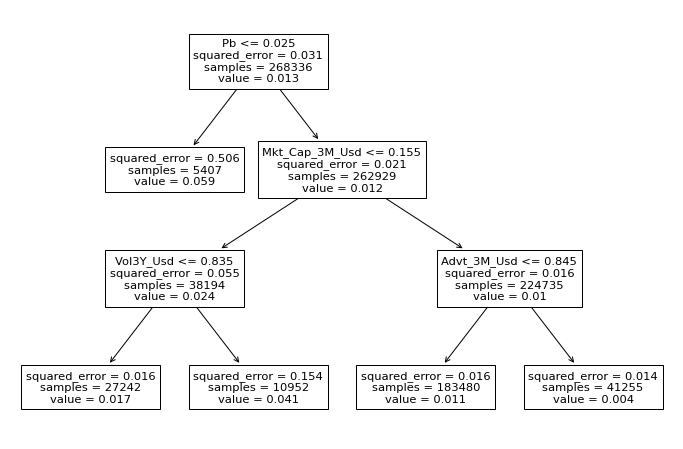

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize = (12, 8))
plot_tree(fit_tree, feature_names = X.columns, ax = ax)
plt.show()

The split is done with a Boolean expression. If the expression is true, then the instance goes to the left cluster; if not, it goes to the right cluster.

The initial split is done with price-to-book ratio. Metrics include number of samples in each node, mean squared error and average value of the label in each node. E.g. the rightmost node with lowest average return satisfy the following conditions:

- Pb score above 0.025
- A 3-month market capitalization score above 0.155
- A score of average daily volume over the past 3 months above 0.845

Note that we have set up some restrictions to avoid some peculiar groups containing a very small number of samples. The complexity of the tree (measured by the number of terminal leaves) is a decreasing function of minbucket, minsplit and cp and an increasing function of maximum depth.

Once the model has been trained, we can use it to predict:

In [34]:
fit_tree.predict(data_ml.iloc[1:6, 2:95])

array([0.01088066, 0.01088066, 0.01088066, 0.01088066, 0.01088066])

As a verification of the first splits, we plot the smoothed average of future returns, conditionally on market capitalization, past return and trading volume.

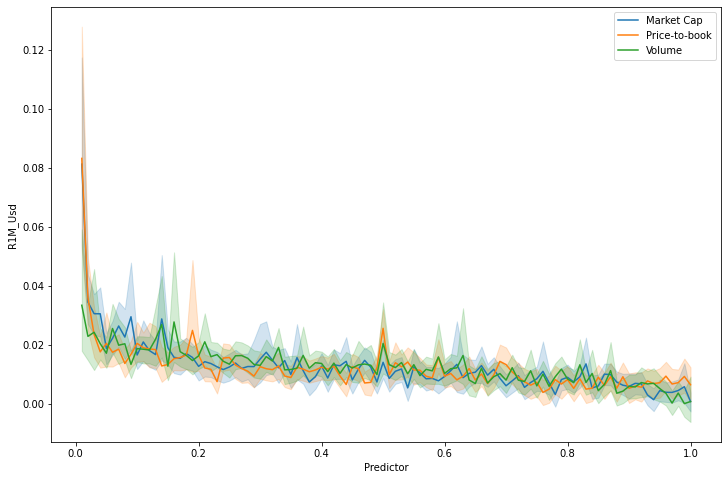

In [44]:
import seaborn as sns
plt.figure(figsize = (12, 8))
sns.lineplot(y = data_ml['R1M_Usd'], x = data_ml['Mkt_Cap_3M_Usd'], label = 'Market Cap')
sns.lineplot(y = data_ml['R1M_Usd'], x = data_ml['Pb'], label = 'Price-to-book')
sns.lineplot(y = data_ml['R1M_Usd'], x = data_ml['Advt_3M_Usd'], label = 'Volume')
plt.xlabel('Predictor')
plt.legend()
plt.show()

The graph shows us that for low values of market cap and price-to-book ratio, the average return is high.

Finally, we assess the predictive quality of a single tree on the testing set (the tree is grown on the training set). We use a deeper tree, with a maximum depth of five.

In [46]:
separation_date = pd.to_datetime('2014-01-15')
training_sample = data_ml[data_ml['date'] < separation_date]
test_sample = data_ml[data_ml['date'] > separation_date]

X_train = training_sample[training_sample.columns[2:95]]
y_train = training_sample['R1M_Usd']

In [49]:
fit_tree2 = DecisionTreeRegressor(min_samples_leaf = 1500, min_samples_split = 4000, max_depth = 5, ccp_alpha = 1e-6)
fit_tree2.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=1e-06, max_depth=5, min_samples_leaf=1500,
                      min_samples_split=4000)

In [53]:
import numpy as np

X_test = test_sample[test_sample.columns[2:95]]
y_test = test_sample['R1M_Usd']
np.power(fit_tree2.predict(X_test) - y_test, 2).mean()

0.03700730671331156

In [55]:
(fit_tree2.predict(X_test) * y_test > 0).mean()

0.5416619188696444

Similarly to prediction results in Chapter 5, the mean squared error is usually hard to interpret. The hit ratio is more intuitive because it evaluates the proportion of correct guesses. It's not perfect since 55% of small gains can be mitigated by 45% large losses.

## Random Forests

Main idea: ensembles in which predicting tools are combined.

### Principle

There are two ways to create multiple predictors from simple trees, and random forests combine both:

- First, the model can be trained on similar yet different datasets. One way to achieve this is via *bootstrap*: resampling with/without replacement
- Second, the data can be altered by curtailing the number of predictors. Alternative models are built based on different sets of features. The user chooses how many features to retain and then the algorithm selects these features randomly at each try.

Idea: grow many different trees and the ensemble is simply **a weighted combination** of all trees. The idea is illustrated as following:

![FIGURE 6.4: Combining tree outputs via random forests](images\figure6-4.png)

In classification tasks, the decision is taken by a majority vote: each tree votes for a particular class and the class with the most votes wins (with possible random picks for ties). Breiman (2001) defines the margin function as
$$mg=M^{-1}\sum_{m=1}^M1_{\{h_m(\boldsymbol{x})=y\}}-\max_{j\neq y}\left(M^{-1}\sum_{m=1}^M1_{\{h_m(\boldsymbol{x})=j\}}\right)$$
where the left part is the average number of votes based on the $M$ trees $h_m$ for the correct class. The right part is the maximum average for other class. The margin reflects *the confidence that the aggregate forest will classify properly.* Breiman (2001) shows that the inaccuracy of the aggregation (as measured by generalization error) is bounded by $\bar{\rho}(1-s^2)/s^2$, where

- $s$ is the strength (average quality) of individual classifiers and
- $\bar{\rho}$ is the average correlation between the learners

Notably, Breiman (2001) also shows that as the number of trees grows to infinity, *the inaccuracy converges to some finite number* which explains why **random forests are not prone to overfitting**.

Regression trees are also discussed in Biau (2012) and Scornet et al. (2015).

### Code and Results

In [61]:
from sklearn.ensemble import RandomForestRegressor

fit_rf = RandomForestRegressor(# bootstrap = False,
                               max_samples = 10000, 
                               n_estimators = 40,
                               max_features = 30,
                               min_samples_split = 250)
fit_rf.fit(X_train, y_train)

RandomForestRegressor(max_features=30, max_samples=10000, min_samples_split=250,
                      n_estimators=40)

In [64]:
fit_rf.predict(X_test[:5])

array([0.00675203, 0.01451932, 0.00950345, 0.00570163, 0.0223777 ])

One first comment is that each instance has its own prediction, which contrasts with the outcome of simple tree-based outcomes. In the above example, each individual learner (tree) is built on 10,000 randomly chosen instances and each terminal leaf (cluster) must comprise at least 250 elements (observations). In total, 40 trees are aggregated and each tree is constructed based on 30 randomly chosen predictors (out of the whole set of features).

Unlike simple trees, the learning process of random forest is hard to illustrate. A simplified view can be obtained via variable importance. Please refer to further details in Chapter 13.

Finally, we can assess the accuracy of the model.

In [66]:
np.power(fit_rf.predict(X_test) - y_test, 2).mean()

0.03695441541183705

In [68]:
(fit_rf.predict(X_test) * y_test > 0).mean()

0.537075546946217

The MSE is smaller than 4% and the hit ratio is close to 54%, which is reasonably above both 50% and 52% thresholds.

Let’s see if we can improve the hit ratio by resorting to a classification exercise. We start by training the model on a new formula (the label is `R1M_Usd_C`).

In [70]:
from sklearn.ensemble import RandomForestClassifier
fit_rf_c = RandomForestClassifier(n_estimators = 40,
                                  min_samples_split = 250,
                                  max_features = 30,
                                  max_samples = 20000)

y_train_c = training_sample['R1M_Usd_C']
fit_rf_c.fit(X_train, y_train_c)

RandomForestClassifier(max_features=30, max_samples=20000,
                       min_samples_split=250, n_estimators=40)

In [71]:
y_test_c = test_sample['R1M_Usd_C']
(fit_rf_c.predict(X_test) == y_test_c).mean()

0.5000712169553327

The accuracy is disappointing. There are two potential explanations for this (beyond the possibility of very different patterns in the training and testing sets):

- Sample size can be too small. We only retain ~10% of the observation.
- Number of predictors is set at 30, only 1/3 of the total at our disposal. This may leave room for the algorithm to pick less pertinent predictors.

The default number of predictors by routines are $\sqrt{p}$ and $p/3$ for classification and regression tasks, where $p$ is the total number of features.

## Boosted Trees: AdaBoost

The idea of boosting is slightly more advanced compared to agnostic aggregation. In random forest, we hope that the diversification through many trees will improve the overall quality of the model. In boosting, it is sought to iteratively improve the model whenever a new tree is added. We will try `AdaBoost` (for adaptive boosting, progressively focusing on the instances that yield the largest errors) and `XGBoost` (flexible, only focused on the minimization of training sample loss).

### Methodology

Origins: Freund and Schapire (1997), Freund and Schapire (1996) and the book dedicated on boosting Schapire and Freund (2012). The algorithm is as follows:

- Set equal weights $w_i=I^{-1}$;
- For $m=1,\dots,M$, do:
  1. Find a learner $l_m$ that minimizes the weighted loss $\sum_{i=1}^I w_i L(l_m(\boldsymbol{x}_i), \boldsymbol{y}_i)$
  2. Compute a learner weight $$a_m=f_a(\boldsymbol{w}, l_m(\boldsymbol{x}), \boldsymbol{y})$$
  3. Update the instance weights $$w_i \leftarrow w_i e^{f_w(\boldsymbol{w}, l_m(\boldsymbol{x}_i), \boldsymbol{y}_i)}$$
  4. Normalize $w_i$ to sum to one.
- The output for instance $\boldsymbol{x}_i$ is a simple function of $\sum_{m=1}^M a_m l_m(\boldsymbol{x}_i)$ as following: $$\tilde{y}_i=f_y\left(\sum_{m=1}^M a_ml_m(\textbf{x}_i) \right)$$

The formulation holds for many variations and we discuss the steps as follows:

1. The first step seeks to find a learner (maybe a tree in this case) that minimizes a weighted loss. The base loss function $L$ especially *depends on the task* (regression vs classfication).
2. The second and third steps are the heart of AdaBoost: sequential adaptation. A natural property (for $f_a$) should be that *a learner that yields a smaller error should have a larger weight because it is more accurate.*
3. The third step is to change the weights of observations. $f_w$ is constructed to give more weight on observations for which the current model does not do a good job (i.e., generates the largest errors). Hence, the next learner will be incentivized to pay more attention on these pathological cases.
4. The final step is a simple scaling (unification) procedure.

Below we detail some examples of weighting functions. Interested readers can have a look at other possibilities in Schapire (2003) and Ridgeway, Madigan, and Richardson (1999).

|  | Bin. classif. (orig. AdaBoost) | Regression (Drucker, 1997) |
| :--: | :--: | :--: |
| Individual Error | $\epsilon_i = \boldsymbol{1}_{y_1\neq l_m(\boldsymbol{x}_i)}$ | $\epsilon_i=\dfrac{\|y_i-l_m(\boldsymbol{x}_i)\|}{\max_i \|y_i-l_m(\boldsymbol{x}_i)\|}$ |
| Weight of learner via $f_a$ | $\epsilon=I^{-1}\sum_{i=1}^Iw_i \epsilon_i$, with $\epsilon=I^{-1}\sum_{i=1}^Iw_i \epsilon_i$ | $\epsilon=I^{-1}\sum_{i=1}^Iw_i \epsilon_i$, with $\epsilon=I^{-1}\sum_{i=1}^Iw_i \epsilon_i$ |
| Weight of instances via $f_w(i)$ | $f_w=f_a\epsilon_i$ | $f_w=f_a\epsilon_i$ |
| Output function via $f_y$ | $f_y(x)=\text{sign}(x)$ | weighted median of predictions |

The basic error term $\epsilon_i = \boldsymbol{1}_{y_1\neq l_m(\boldsymbol{x}_i)}$ is a dummy number indicating if the prediction is correct (binary case). The average error $\epsilon \in [0,1]$ is simply a weighted average of individual errors and the weight of the $m^{th}$ learner is given by $a_m=\log(\frac{1-\epsilon}{\epsilon})$. The function $x\mapsto \log((1-x)x^{-1})$ decreases on $[0,1]$ and switches sign (from positive to negative) at $x=1/2$. Hence, when the average error is small (or large), the learner will obtain a large positive (or even negative, which is obvious since $\epsilon>1/2$ indicates a problem) weight.

The change in instance weights follows a similar logic. The new weight is proportional to $w_i (\frac{1-\epsilon}{\epsilon})^{\epsilon_i}$. If the prediction is right and $\epsilon_i=0$, then the weight will remain unchanged. If the prediction is wrong and $\epsilon_i=1$, then the weight is adjusted. If the error is small and the learner is efficient ($\epsilon<1/2$) then $(1-\epsilon)/\epsilon>1$ and the weight of the instance will increase for new learners to focus more on it.

Lastly, the final prediction of the model corresponds to the sign of the weighted sum of individual predictions: positive -> +1, otherwise -> -1.

There are two ways to deal with instance weighting. The first one works at the level of the loss functions. For regression trees, Equation (6.1) would naturally generalize to
$$V^{(k)}_N(c^{(k}), \boldsymbol{w})= \sum_{x_i^{(k)}<c^{(k)}}w_i\left(y_i-m_N^{k,-}(c^{(k)}) \right)^2 + \sum_{x_i^{(k)}>c^{(k)}}w_i\left(y_i-m_N^{k,+}(c^{(k)}) \right)^2$$
and hence an instance with a large weight $w_i$ would contribute more to the dispersion of the cluster. For classification objectives the alternation is more complex and you may refer to Ting (2002).

The second way to enforce instance weighting is via *random sampling*. If instances have weights $w_i$, then the training of learners can be performed over a sample that is randomly extracted with distribution equal to $w_i$ (in fact, the original Adaboost algorithm relies on this method).

### Illustration

Below, we test an implementation of the original adaboost classifier. As such, we work with the R1M_Usd_C variable and change the model formula. The computational cost of adaboost is high on large datasets, thus we work with a smaller sample and we only impose three iterations.

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

fit_adaboost_C = AdaBoostClassifier(DecisionTreeClassifier(
        max_depth = 3), # depth of the tree
        n_estimators = 3) # Number of trees 
fit_adaboost_C.fit(X_train, y_train_c) # Fitting the model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=3)

In [73]:
(fit_adaboost_C.predict(X_test) == y_test_c).mean()

0.49641066545123064

The accuracy (as evaluated by the hit ratio) is clearly not satisfactory. One reason for this may be the restrictions we enforced for the training (smaller sample and only three trees).

## Boosted Trees: Extreme Gradient Boosting

The idea of tree bossting can be generalized as following: at each step $s$, the sum of models $M_S=\sum_{s=1}^{S-1} m_s+m_S$ is such that the last learner $m_S$ was precisely designed to reduce the loss of $M_S$ on the training sample.

XGBoost is originally proposed by Chen and Guestrin (2016) with incredibly accurate predictions and is highly customizable. The other popular alternative is LightGBM (Ke et al., 2017). XGBoost seeks to minimize the objective 
$$O=\underbrace{\sum_{i=1}^I \text{loss}(y_i,\tilde{y}_i)}_{\text{error term}} \quad + \underbrace{\sum_{j=1}^J\Omega(T_j)}_{\text{regularisation term}}$$
The first term (over all instances) measures the distance between the true label and the output from the model. The secon term *penalizes models that are too complex.*

For simplicity, we propose the full derivation with the simplest loss function $Loss(y, \tilde{y})=(y-\tilde{y})^2$, so that
$$O=\sum_{i=1}^I \left(y_i-m_{J-1}(\boldsymbol{x}_i)-T_J(\boldsymbol{x}_i)\right)^2+ \sum_{j=1}^J\Omega(T_j)$$

### Managing Loss

Let us assume that we have already built all trees $T_j$ up to $j=1,\dots,J-1$ (and hence model $M_{J-1}$). Then, *how to choose tree $T_j$ optimally*? We rewrite
\begin{align*}
O&=\sum_{i=1}^I \left(y_i-m_{J-1}(\mathbf{x}_i)-T_J(\mathbf{x}_i)\right)^2+ \sum_{j=1}^J\Omega(T_j) \\
&=\sum_{i=1}^I\left\{y_i^2+m_{J-1}(\mathbf{x}_i)^2+T_J(\mathbf{x}_i)^2 \right\} + \sum_{j=1}^{J-1}\Omega(T_j)+\Omega(T_J) \quad \text{(squared terms + penalisation)}\\
& \quad -2 \sum_{i=1}^I\left\{y_im_{J-1}(\mathbf{x}_i)+y_iT_J(\mathbf{x}_i)-m_{J-1}(\mathbf{x}_i) T_J(\mathbf{x}_i))\right\}\quad \text{(cross terms)} \\
&= \sum_{i=1}^I\left\{-2 y_iT_J(\mathbf{x}_i)+2m_{J-1}(\mathbf{x}_i) T_J(\mathbf{x}_i))+T_J(\mathbf{x}_i)^2 \right\} +\Omega(T_J) + c
\end{align*}
All terms known at step $J$ (i.e. indexed by $J-1$) vanish because they do not enter the optimization scheme and are embedded in the constant $c$.

Things are fairly simple with the quadratic loss. For more complicated loss functions, Taylor expansions are used.

### Penalization

For a given tree $T$, we specify its structure by $T(x)=w_{q(x)}$, where $w$ is the output value of some leaf $q(\cdot)$ is the function that maps an input to its final leaf. The function $q$ indicates the path, while the vector $\boldsymbol{w}=w_i$ codes the terminal leaf values.

![FIGURE 6.5: Coding a decision tree: decomposition between structure and node and leaf values.](images\figure6-5.png)

We write $l=1,\dots,L$ for the indices of the leaves of the tree. In XGBoost, complexity is defined as
$$\Omega(T)=\gamma L+\frac{\lambda}{2}\sum_{l=1}^Lw_l^2$$
where

- The first term penalizes the **total number of leaves**;
- The second term penalizes **the magnitude of output values** (which helps reduce variance)

The first penalization term *reduces the depth of the tree*, while the second *shrinks the size of the adjustments that will come from the latest tree*.

### Aggregation

We aggregate both sections of the objective (loss and penalization). We write $I_l$ for the set of the indices of the instances belonging to leaf $l$. Then
\begin{align*}
O&= 2\sum_{i=1}^I\left\{ -y_iT_J(\mathbf{x}_i)+m_{J-1}(\mathbf{x}_i) T_J(\mathbf{x}_i)+\frac{T_J(\mathbf{x}_i)^2}{2} \right\} + \gamma L+\frac{\lambda}{2}\sum_{l=1}^Lw_l^2 \\
&=2\sum_{i=1}^I\left\{- y_iw_{q(\mathbf{x}_i)}+m_{J-1}(\mathbf{x}_i)w_{q(\mathbf{x}_i)}+\frac{w_{q(\mathbf{x}_i)}^2}{2} \right\} + \gamma L+\frac{\lambda}{2}\sum_{l=1}^Lw_l^2 \\
&=2 \sum_{l=1}^L \left(w_l\sum_{i\in I_l}(-y_i +m_{J-1}(\mathbf{x}_i))+ \frac{w_l^2}{2}\sum_{i\in I_l}\left(1+\frac{\lambda}{2}\right)\right)+ \gamma L
\end{align*}
The function is of the form $aw_l+\frac{b}{2}w_l^2$, which has minimum values $-a^2/(2b)$ at point $w_l=-a/b$. Thus, writing $\#(.)$ for the cardinal function that counts the number of items in a set
\begin{align*}
\mathbf{\rightarrow} \quad w^*_l&=\frac{\sum_{i\in I_l}(y_i -m_{J-1}(\mathbf{x}_i))}{\left(1+\frac{\lambda}{2}\right)\#\{i\in I_l\}}, \text{ so that} \\
O_L(q)&=-\frac{1}{2}\sum_{l=1}^L \frac{\left(\sum_{i\in I_l}(y_i -m_{J-1}(\mathbf{x}_i))\right)^2}{\left(1+\frac{\lambda}{2}\right)\#\{i\in I_l\}}+\gamma L
\end{align*}
where we added the dependence of the objective both in $q$ (structure of tree) and $L$ (number of leaves). Indeed, the meta-shape of the tree remains to be determined.

### Tree Structure

Similar to simple trees: features must be tested in order to pick one that minimizes the objective for each given split. What's the best depth and when to stop growing the tree?

- Proceed node-by-node
- For each node, look at whether a split is useful or not $$\text{Gain}=\frac{1}{2}\left(\text{Gain}_L+\text{Gain}_R-\text{Gain}_O \right)-\gamma$$
- Each gain is computed with respect to the instances in each bucket (cluster): $$\text{Gain}_{\mathcal{X}}= \frac{\left(\sum_{i\in I_{\mathcal{X}}}(y_i -m_{J-1}(\mathbf{x}_i))\right)^2}{\left(1+\frac{\lambda}{2}\right)\#\{i\in I_{\mathcal{X}}\}}$$ where $I_{\mathcal{X}}$ is the set of instances within cluster $\mathcal{X}$.

$\text{Gain}_{O}$ is the original gain (without split), and $\text{Gain}_{L}$ and $\text{Gain}_{R}$ are the gains of the left and right clusters respectively. The $-\gamma$ term measures a penalization: adding a split will makes *one leaf difference*, hence $\Delta L=1$ and the penalization intensity is $\gamma$.

Lastly, we underline the fact that XGBoost also applies a **learning rate**: each new tree is scaled by a factor $\eta$ with $\eta \in [0,1]$. After each step of boosting the new tree $T_J$ sees its values discounted by multiplying them by $\eta$.

### Extensions

Several additional features are available to further prevent boosted trees to overfit.

- Rashmi and Gilad-Bachrach (2015): the *DART* (Dropout for Additive Regression Trees). Thd idea is to omit a specified number of trees (chosen randomly) during training. The full specifications can be found [here](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html).
- Monotonicity constraints: one particular feature has a monotonic impact on the label. You may refer to Figure 6.6 below to see how the algorithm proceeds. If a split violates the bounds given by previous splits for acceptable values, it is *overlooked* and *another variable will be chosen instead*.

![FIGURE 6.6: Imposing monotonic constraints. The constraints are shown in bold blue in the bottom leaves.](images\figure6-6.png)

### Code and Results

For Python, we will choose the `xgboost` library. Moreover, because training times can be long, we shorten the training sample as advocated in Coqueret and Guida (2020). We retain only the 40% most extreme observations (in terms of label values: top 20% and bottom 20%) and work with the small subset of features. In all coding sections dedicated to boosted trees in this book, the models will be trained with only 7 features.

In [81]:
import xgboost as xgb

r1m_use_quantiles = (training_sample['R1M_Usd'].quantile(0.2), training_sample['R1M_Usd'].quantile(0.8))
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

training_samples_xgb = training_sample[(training_sample['R1M_Usd'] < r1m_use_quantiles[0]) | (training_sample['R1M_Usd'] > r1m_use_quantiles[1])].reset_index().drop(columns = 'index')

training_features_xgb = training_samples_xgb[features_short]
training_label_xgb = training_samples_xgb['R1M_Usd']
train_matrix_xgb = xgb.DMatrix(data = training_features_xgb, label = training_label_xgb)

The second (optional) step is to determine the monotonicity constraints that we want to impose. For simplicity, we will only enforce three constraints on

1. Market capitalization (negative, because large firms have smaller returns under the size anomaly);
2. Price-to-book ratio (negative, because overvalued firms also have smaller returns under the value anomaly);
3. Past annual returns (positive, because winners outperform losers under the momentum anomaly).

In [82]:
# DECREASING in market cap, price-to-book; INCREASING in past return
mono_const = (0, 0, -1, 1, 0, -1, 0)

The third step is to train the model on the formatted training data. We include the monotonicity constraints and the DART feature (via rate_drop). Just like random forests, boosted trees can grow individual trees on subsets of the data: both row-wise (by selecting random instances) and column-wise (by keeping a smaller portion of predictors). These options are implemented below with the subsample and colsample_bytree in the arguments of the function.

For compatibility with `sklearn`, in Python we will try to apply a `sklearn`-like API to complete the training task. The codes are as follows:

In [115]:
fit_xgb = xgb.XGBRegressor(learning_rate = 0.3,
                           max_depth = 4,
                           subsample = 0.6,
                           colsample_bytree = 0.7,
                           reg_lambda = 1,
                           gamma = 0.1,
                           n_estimators = 30,
                           monotone_constraints = mono_const,
                           rate_drop = 0.1,
                           booster = 'dart')
fit_xgb.fit(X = training_features_xgb, y = training_label_xgb)

XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints=(0, 0, -1, 1, 0, -1, 0), n_estimators=30,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Finally, we evaluate the performance of the model. Note that before that, a proper formatting of the testing sample is required.

In [116]:
xgb_test = test_sample[features_short]
np.power(fit_xgb.predict(xgb_test) - test_sample['R1M_Usd'], 2).mean()

0.0373759307683367

In [118]:
(fit_xgb.predict(xgb_test) * test_sample['R1M_Usd'] >= 0).mean()

0.5079193254329991

The performance is comparable to those observed for other predictive tools. As a final exercise, we show one implementation of a classification task under XGBoost. Only the label changes. In XGBoost, labels must be coded with integer number, starting at zero exactly.

When working with categories, the loss function is usually the softmax function (see Section 2.1).

In [105]:
training_label_c = training_samples_xgb['R1M_Usd_C']

fit_xgb_c = xgb.XGBClassifier(learning_rate = 0.8,
                              objective = "multi:softmax",
                              num_class = 2,
                              max_depth = 4,
                              n_estimators = 10,
                              verbosity = 0)
fit_xgb_c.fit(training_features_xgb, training_label_c)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.8, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0, num_class=2,
              num_parallel_tree=1, objective='multi:softmax', ...)

We can then proceed to the assessment of the quality of the model. 

In [111]:
(fit_xgb_c.predict(xgb_test) == test_sample['R1M_Usd_C']).mean()

0.4956130355515041

Consistently with the previous classification attempts, the results are underwhelming, as if switching to binary labels incurred a loss of information.

### Instance Weighting

In the computation of the aggregate loss, it's possible to introduce some flexibility and assign weights to instances:
$$O=\underbrace{\sum_{i=1}^I\mathcal{W}_i \times \text{loss}(y_i,\tilde{y}_i)}_{\text{weighted error term}} \quad + \underbrace{\sum_{j=1}^J\Omega(T_j)}_{\text{regularization term (unchanged)}}$$
In factor investing, these weights can very well depend on the feature values $(\mathcal{W}_i=\mathcal{W}_i(\boldsymbol{x}_i))$. Weights can be set through some of the following ways:

- Assign more importance to assets with high values of one particular characteristic
- Increase weights when the values of the characteristic become extreme (e.g. deep value and deep growth stocks). For uniform features, you may simply set $\mathcal{W}_i(x_i^k) \propto |x_i^k-0.5|$

In XGBoost, the implementation instance weighting is done very early in the definition of the `xgb.DMatrix`. For `sklearn`-like objects, you may specify the parameter `sample_weight` in `XGBRegressor.fit(X, y, sample_weight)`.

In [121]:
inst_weights = np.random.uniform(0, 1, size = training_features_xgb.shape[0])
inst_weights /= sum(inst_weights)
fit_xgb.fit(training_features_xgb, training_label_xgb, sample_weight = inst_weights)

XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints=(0, 0, -1, 1, 0, -1, 0), n_estimators=30,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Then, in the subsequent stages, the optimization will be performed with these hard-coded weights. The splitting points can be altered (via the total weighted loss in clusters) and the terminal weight values (6.5) are also impacted.

## Discussion

- Signals given by ML must be translated into portfolio weights
- **Simple trees appear suboptimal**: tree depth are usually set between 3 and 6, which implies between 8 and 64 terminal leaves at most, with possibly very *unbalanced clusters*. This means that when it comes to predictions, roughly 20% to 30% of the instances will be given the same value.
- This does not permit to discriminate and set a subset if the portfolio requires 100 stocks while 105 stocks have the same signal.
- **Preference to aggregate models!** In practive, random forests and booted trees are best choices.

## Coding Exercises

1. Using the formula in the chunks above, build two simple trees on the training sample with only one parameter: cp. For the first tree, take cp=0.001 and for the second take cp=0.01. Evaluate the performance of both models on the testing sample. Comment.

In [130]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

features = training_sample.columns[2:95]
X_train, y_train, X_test, y_test = training_sample[features], training_sample['R1M_Usd'], test_sample[features], test_sample['R1M_Usd']

fit_tree = DecisionTreeRegressor(ccp_alpha = 0.01)
fit_tree.fit(X_train, y_train) # 193.1s taken to fit

DecisionTreeRegressor(ccp_alpha=0.01)

In [131]:
print('Test Sample MSE:', np.power(fit_tree.predict(X_test) - y_test, 2).mean())
print('Test Sample Hit Ratio:', (fit_tree.predict(X_test) * y_test > 0).mean())

Test Sample MSE: 0.03700730671331156
Test Sample Hit Ratio: 0.5416619188696444


In [ ]:
fit_tree = DecisionTreeRegressor(ccp_alpha = 0.001)
fit_tree.fit(X_train, y_train) #  taken to fit

In [133]:
print('Test Sample MSE:', np.power(fit_tree.predict(X_test) - y_test, 2).mean())
print('Test Sample Hit Ratio:', (fit_tree.predict(X_test) * y_test > 0).mean())

Test Sample MSE: 0.03699695809184935
Test Sample Hit Ratio: 0.5460346399270738


2. With the smaller set of predictors, build random forests on the training sample. Restrict the learning on 30,000 instances and over 5 predictors. Construct the forests on 10, 20, 40, 80 and 160 trees and evaluate their performance on the training sample. Is complexity worthwhile in this case and why?

In [134]:
from sklearn.ensemble import RandomForestRegressor

n_trees = [10, 20, 40, 80, 160]
mses, hit_ratios = [], []

for n_tree in n_trees:
    fit_rf = RandomForestRegressor(max_samples = 30000, 
                                   n_estimators = n_tree,
                                   max_features = 5)
    fit_rf.fit(X_train, y_train)
    mse = np.power(fit_rf.predict(X_test) - y_test, 2).mean()
    hit_ratio = (fit_rf.predict(X_test) * y_test > 0).mean()
    mses.append(mse)
    hit_ratios.append(hit_ratio)
print('MSE:', mses)
print('Hit Ratios:', hit_ratios)

MSE: [0.04253661846926196, 0.03933268492522167, 0.03742240925663674, 0.03722276686730436, 0.036810498494703234]
Hit Ratios: [0.506324065633546, 0.5096712625341842, 0.5180463764813127, 0.523515838650866, 0.5268487921604376]


Trees are by definition random so results can vary from test to test. Overall, large numbers of trees are preferable and the reason is that each new tree tells a new story and diversifies the risk of the whole forest.

3. Plot a tree based on data from calendar year 2008 and then from 2009. Compare.

In [156]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

def plot_tree_year(sample, year):
    training_sample = sample.copy()
    training_sample = training_sample.reset_index().drop(columns = 'index')
    training_sample['year'] = training_sample['date'].apply(lambda x: x.year)
    training_sample_year = training_sample[training_sample['year'] == year]

    X_train, y_train = training_sample_year[features], training_sample_year['R1M_Usd']

    fit_tree = DecisionTreeRegressor(ccp_alpha = 1e-5, max_depth = 2)
    fit_tree.fit(X_train, y_train)

    fig, ax = plt.subplots(figsize = (12, 8))
    plot_tree(fit_tree, feature_names = training_sample_year.columns, ax = ax)
    plt.show()

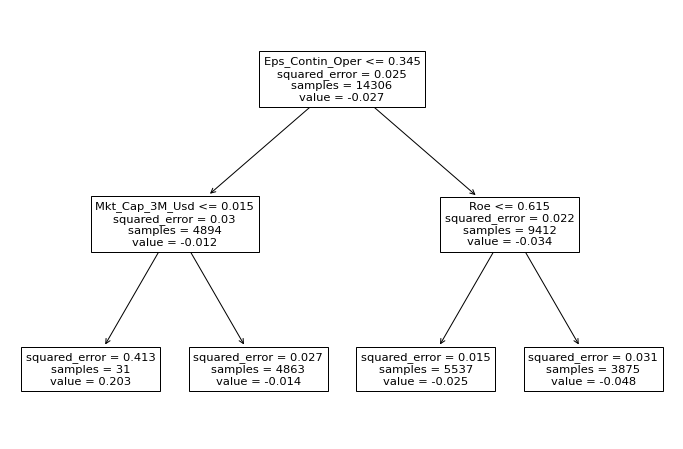

In [157]:
plot_tree_year(training_sample, 2008)

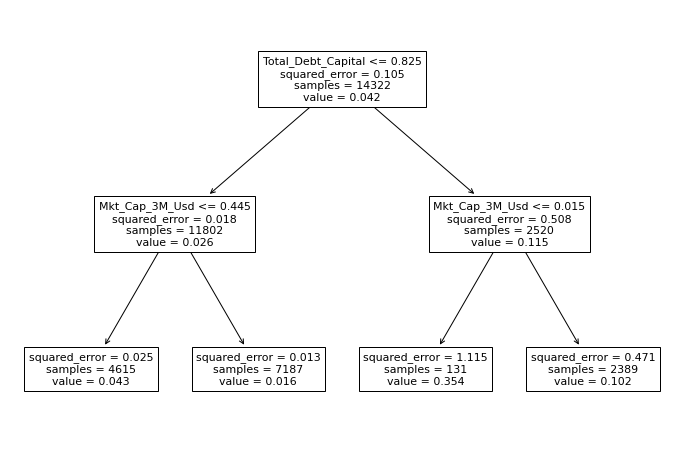

In [158]:
plot_tree_year(training_sample, 2009)

## Takeaways

- Simple Decision Trees
  - Minimize total variability (or dispersion) inside each cluster
  - Impurity metrics: Gini Index, Entropy and the misclassification error
  - Pruning: minimal number of instances within each leaf, minimal sample size for splitting, improving threshold, maximum depth, etc.

- Random Forests
  - Model Aggregation: Bagging
  - Main idea of RF: bootstrap of sample, curtailing the number of predictors, and majority vote (for classification)

- Boosted Trees: AdaBoost
  - Model Aggregation: Boosting
  - Main idea: boosting base learners, increasing the weight of those learner performing well, assigning more weights to instances with large aggregate error (by redefining error functions or random sampling)

- Boosted Trees: XGBoost
  - Boosting, with incredibly good accuracy and customization
  - Penalization for total number of leaves and magnitude of output values, and apply these to tree growth
  - DART for random dropout of trees, monotonicity constraints to constrain that one particular feature has a monotonic impact on the label

- Application in Factor Investing: random forests and boosted trees are suggested for better discrimination with stocks